In [21]:
import plotly_express as px
import pandas as pd
import numpy as np
import wordcloud
import matplotlib.pyplot as plt
import nltk
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from time import time
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from nltk.tokenize import word_tokenize
from sklearn.ensemble import RandomForestClassifier

def generate_data(gender):
    file = open('../train_dataset/'+gender+'.txt', 'r')
    file_line = file.readlines()
    data_list=[]
    for line in file_line:
        data_list.append(line)
    df=pd.DataFrame(data_list)
    df['gender']=gender
    return df


In [3]:
male_df=generate_data('male')
female_df=generate_data('female')

In [4]:
all_df=male_df.append(female_df)
#reset the index
all_df.reset_index(drop=True, inplace=True)


In [5]:
#remove the last 2 strings

def remove_last2char(txt):
    txt=txt[:-2]
    return txt
all_df['text'] = all_df[0].apply(lambda txt: remove_last2char(txt))
del all_df[0]

In [6]:
fig = px.histogram(all_df, x="gender", color="gender", color_discrete_sequence=["#871fff","#ffa78c"])
fig.show()

In [7]:
#We have a balanced dataset which is a good sign

#Something that might be worth looking at is the length of text for each record. Let us create a filed for this
all_df['msg_length'] = all_df['text'].apply(len)
all_df.head()

gender                                           text  msg_length
0   male               No one say you have to were a br          32
1   male               Why are u not showing ur face hm          32
2   male                                  Where u in sh          13
3   male  Nice you look very beautiful with your make u          45
4   male                              You can't tell th          17

In [8]:
gender=['male','female']
for c in gender:
    m_df=all_df[all_df['gender']==c]
    fig = px.histogram(m_df, x="msg_length", color="gender", color_discrete_sequence=["#871fff","#ffa78c"])
    fig.show()


In [9]:
#From the visualization Above, text length seem to be around the same quantity so this will be of not much use to us we can drop it
del all_df['msg_length']

In [10]:
data_male  = all_df[all_df['gender'] == "male"].copy()
data_female = all_df[all_df['gender'] == "female"].copy()

def show_wordcloud(df, title):
    text = ' '.join(df['text'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords, background_color="#ffa78c",
                                        width = 3000, height = 2000).generate(text)
    plt.figure(figsize=(15,15), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

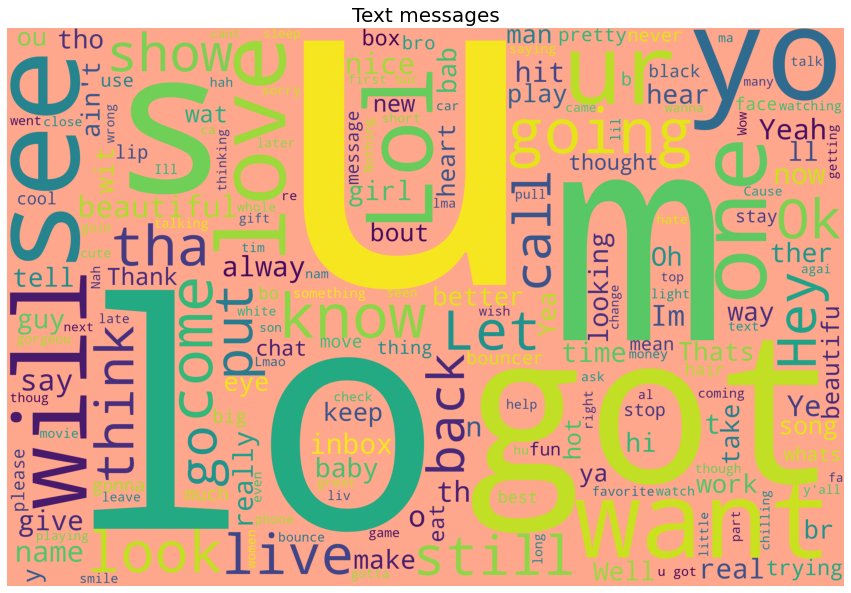

In [19]:
show_wordcloud(data_male, "Text messages")

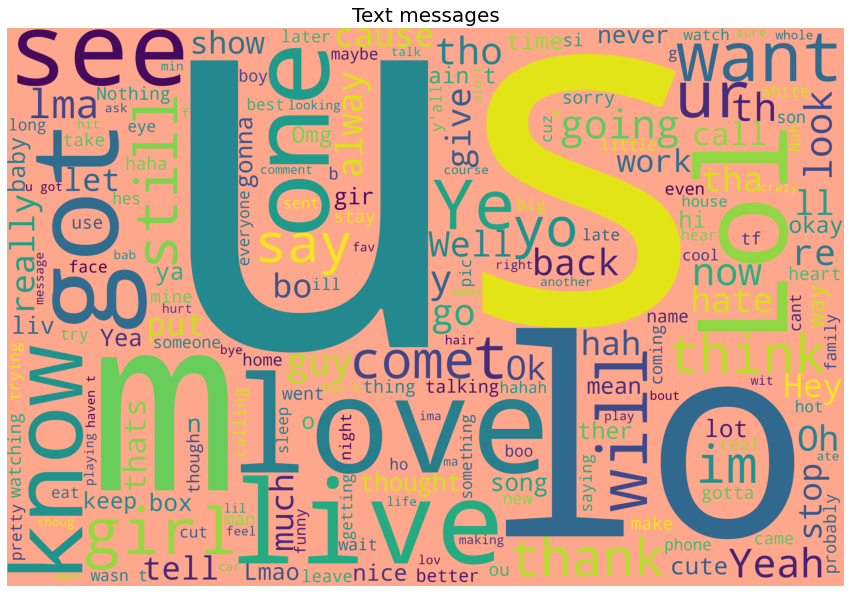

In [20]:
show_wordcloud(data_female, "Text messages")

In [11]:

#covert gender field to numeric
all_df['gender'] = all_df['gender'].map( {'male': 1, 'female': 0})
all_df

gender                                               text
0           1                   No one say you have to were a br
1           1                   Why are u not showing ur face hm
2           1                                      Where u in sh
3           1      Nice you look very beautiful with your make u
4           1                                  You can't tell th
...       ...                                                ...
59927       0                              Loljust helping ya ou
59928       0          I work as a waitress at the awful waffle 
59929       0  Coz when we prepare rice or cook rice we rinse...
59930       0                                   The prop is back
59931       0                                Norrell hey boo 😘😘😘

[59932 rows x 2 columns]

In [12]:

Y = all_df['gender']
X = all_df.drop('gender',axis=1)

#let is visualize our new training set data balance
fig = px.histogram(all_df, x="gender", color="gender", color_discrete_sequence=["#871fff","#ffa78c"])
#fig.show()

In [13]:
#Custom transformer

from sklearn.base import BaseEstimator, TransformerMixin

class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
    
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]
    def fit(self, X, y=None, **fit_params):
        return self
    def get_params(self, deep=True):
        return {}

class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()
#Create a function to do the following Cleanup Respectively
    # remove punctuation
    # remove whitespace between terms with single space
    # remove leading and trailing whitespace
    #all_df['text'] = all_df['text'].str.replace(r'^\s+|\s*?$', ' ')
    # change words to lower case
def clean_text(txt):
    clean_txt=txt.replace(r'[^\w\d\s]', ' ')
    clean_txt=clean_txt.replace(r'\s+', ' ')
    clean_txt=clean_txt.replace(r'^\s+|\s*?$', ' ')
    clean_txt=clean_txt.strip().lower()
    return clean_txt


In [14]:
#we will also create a function that tokenizes our texts and removes stop words
from nltk.corpus import stopwords
def tokenizer(sentence):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(sentence)
    filtered_sentence=[w for w in word_tokens if w not in stop_words]
    return filtered_sentence

#we will implememnt technique called nftdf. This will display word relevance
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(tokenizer=tokenizer)
#tfidf_vec=tfidf_model.fit_transform(text_df)

In [15]:
#before applying the functions, for transformation, we will split our data into Train and Test
target = all_df['gender']

all_df['gender'] = target

Y = all_df['gender']
X = all_df.drop('gender',axis=1)

# splitting training data into train and validation using sklearn
from sklearn import model_selection
X_train,X_test,y_train,y_test = model_selection.train_test_split(X,Y,test_size=.2, random_state=42)


In [16]:
#Verify Feature Training Data Once more
X_train

text
4559                                  Me too went to vel
55728                                    He is so big 😻❤
26048                      Back to this money cutie.....
27090  I got what you looking for..ahhh.. you ain't g...
4071   Like I have an app for certain people just to ...
...                                                  ...
54343          Jeff we’re not together anymore. It’s ove
38158            Girl bye! Y’all haven’t even met him!!!
860                   Do you have away to get out of tow
15795                           She betta sit on the fac
56422                      U still the cutiest thing eve

[47945 rows x 1 columns]

In [17]:
#Verify Target Training Data Once more
y_train

4559     1
55728    0
26048    1
27090    1
4071     1
        ..
54343    0
38158    0
860      1
15795    1
56422    0
Name: gender, Length: 47945, dtype: int64

In [18]:
# Create the  pipeline to clean, tokenize, vectorize
feature_pipe = Pipeline([
                 ('selector', TextSelector(key='text')),
                 ("cleaner", predictors()),
                 ('tfidf', vectorizer),
                 ('to_dense', DenseTransformer()), 
                ]
               )


# Building Out Algorithm
Our Training Data is evenly distrubuted between both classes (Male & Female). Therefore, Accuracy will be the Metrics of Interest to us.
We Will with Naive Bayes Classifier

In [19]:
# We will create a small function that will predict and return few metrics on accuracy and training durartion
def run_prediction(pipeline):
    t0 = time()
    pipeline.fit(X_train,y_train)
    print ("training time:", round(time()-t0, 3), "s")

    t0 = time()
    labels_pred=pipeline.predict(X_test)
    print ("prediction time:", round(time()-t0, 3), "s")
    # Calculate accuracy percentage
    # actual=labels_test
    # predicted=labels_pred
    y_pred=labels_pred


    print(accuracy_score(y_test,y_pred))
    #########################################################




In [35]:
#create another pipeline for our prediction. 
#We will start with Multinomial NB classifier 
pred_pipe = Pipeline([
                 ('feature_processing', feature_pipe),
                 ('classifier', MultinomialNB())
                ]
               )

run_prediction(pred_pipe)

training time: 77.098 s
prediction time: 17.418 s
0.7229498623508801


In [37]:
#The Next Algorithm We will be trying is Decision Tree Algorithm
pred_pipe = Pipeline([
                 ('feature_processing', feature_pipe),
                 ('classifier', DecisionTreeClassifier(random_state=0))
                ]
               )

#run_prediction(pred_pipe)

In [251]:
pred_pipe = Pipeline([
                 ('feature_processing', feature_pipe),
                 ('classifier', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, max_iter=20, random_state=42))
                ]
               )

run_prediction(pred_pipe)

training time: 44.964 s
prediction time: 3.629 s
0.5983982647868524


# Support does not seem to be Impressive. We will try another Algorithm

In [1]:
pred_pipe = Pipeline([
                 ('feature_processing', feature_pipe),
                 ('classifier', SVC(kernel = 'linear', C=10))
                ]
               )

run_prediction(pred_pipe)


NameError: name 'Pipeline' is not defined

In [22]:
pred_pipe = Pipeline([
                 ('feature_processing', feature_pipe),
                 ('classifier', RandomForestClassifier(max_depth=2, random_state=0))
                ]
               )

run_prediction(pred_pipe)


training time: 100.974 s
prediction time: 17.282 s
0.5893885042128973


In [236]:
labels_pred=pred_pipe.predict(X_test)
print ("prediction time:", round(time()-t0, 3), "s")
# Calculate accuracy percentage
# actual=labels_test
# predicted=labels_pred
y_pred=labels_pred


print(accuracy_score(y_test,y_pred))

NotFittedError: This MultinomialNB instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [40]:
all_df['new_msg_length'] = all_df['text'].apply(len)
all_df.head()

gender                     text  new_msg_length
0       1               one say br              10
1       1        u show ur face hm              17
2       1                     u sh               4
3       1  nice look beauti make u              23
4       1                  tell th               7

In [125]:
#create a bag of word model
text_df = all_df['text']
from nltk.tokenize import word_tokenize

# creating a bag-of-words model
all_words = []
for text in text_df:
    words = word_tokenize(text)
    for w in words:
        all_words.append(w)
     
all_words = nltk.FreqDist(all_words)  

In [42]:
print('Number of words: {}'.format(len(all_words)))

Number of words: 18198


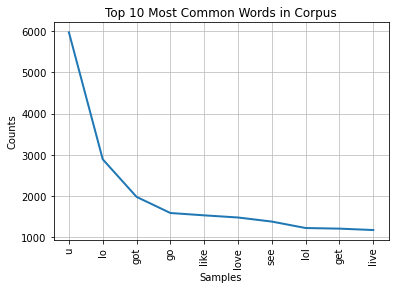

In [43]:
all_words.plot(10, title='Top 10 Most Common Words in Corpus');

In [45]:
#we will implememnt technique called nftdf. This will display word relevance
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_model = TfidfVectorizer()
tfidf_vec=tfidf_model.fit_transform(text_df)
import pickle
#serializing our model to a file called model.pkl
pickle.dump(tfidf_model, open("../model/tfidf_model.pkl","wb"))
tfidf_data=pd.DataFrame(tfidf_vec.toarray())
tfidf_data

0      1      2      3      4      5      6      7      8      9      \
0        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
59927    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
59928    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
59929    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
59930    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
59931    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

       ...  18154  18155  18156  18157  18158  18159  18160  18161  18162  \
0      ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1      ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2      ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3      ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4      ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
59927  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
59928  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
59929  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
59930  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
59931  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

       18163  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0  
...      ...  
59927    0.0  
59928    0.0  
59929    0.0  
59930    0.0  
59931    0.0  

[59932 rows x 18164 columns]

In [88]:
#let us split our data into train and test
### Separating Columns
# train_size=int(0.8*len(tfidf_data))
# df_train = tfidf_data.iloc[:train_size]
# df_test = tfidf_data.iloc[train_size:]

target = all_df['gender']

tfidf_data['gender'] = target

Y = tfidf_data['gender']
X = tfidf_data.drop('gender',axis=1)

# splitting training data into train and validation using sklearn
from sklearn import model_selection
X_train,X_test,y_train,y_test = model_selection.train_test_split(X,Y,test_size=.2, random_state=42)


In [105]:
#Building the Algo
#This is a clasfficiation problem 
#We will start by trying different algo and evaluate their aacuracy score.
# Its always good to start from less complex models, optimize them and if the scores are not satisfactory, we can move to other models
# We will start with Naive Bayes. It takes less time time to train


In [58]:
clf = GaussianNB()
t0 = time()
clf.fit(X_train, y_train)
print ("training time:", round(time()-t0, 3), "s")

t0 = time()
labels_pred=clf.predict(X_test)
print ("prediction time:", round(time()-t0, 3), "s")
# Calculate accuracy percentage
# actual=labels_test
# predicted=labels_pred
y_pred=labels_pred


print(accuracy_score(y_test,y_pred))
#########################################################

training time: 71.402 s
prediction time: 5.781 s
0.5606073246016517


In [182]:

text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB()),
 ])
text_clf = text_clf.fit(X_train, y_train)
text_clf

ValueError: Found input variables with inconsistent numbers of samples: [1, 47945]

In [286]:

def decision_tree():    
    clf = DecisionTreeClassifier(min_samples_split=40)
    t0 = time()
    clf.fit(X_train, y_train)
    print ("training time:", round(time()-t0, 3), "s")
    t0 = time()
    labels_pred=clf.predict(X_test)
    print ("prediction time:", round(time()-t0, 3), "s")
    # Calculate accuracy percentage
    # actual=labels_test
    # predicted=labels_pred
    y_pred=labels_pred


    print(accuracy_score(y_test,y_pred))
    #########################################################

In [ ]:
#########################################################
clf = SVC(kernel = 'rbf', C=10000)
t0 = time()
clf.fit(X_train, y_train)
print ("training time:", round(time()-t0, 3), "s")
t0 = time()
labels_pred=clf.predict(X_test)
print ("prediction time:", round(time()-t0, 3), "s")
# Calculate accuracy percentage
# actual=labels_test
# predicted=labels_pred
y_pred=labels_pred


print(accuracy_score(y_test,y_pred))
#########################################################

In [ ]:
class Preprocess(BaseEstimator, TransformerMixin):
    def __init__(self, stopwords=None, punct=None,
                 lower=True, strip=True):
        self.lower      = lower
        self.strip      = strip
        self.stopwords  = stopwords or set(sw.words('english'))
        self.punct      = punct or set(string.punctuation)
        self.lemmatizer = WordNetLemmatizer()

    def fit(self, X, y=None):
        return self

    def inverse_transform(self, X):
        return [" ".join(doc) for doc in X]

    def transform(self, X):
        return [
            list(self.tokenize(doc)) for doc in X
        ]
